# Heart Disease Prediction

The World Health Organization (WHO) estimates that 17.9 million people die from cardiovascular diseases (CVDs) every year.

There are multiple risk factors that could contribute to CVD in an individual, such as unhealthy diet, lack of physical activity, or mental illness. Identifying these risk factors early on could help prevent many premature deaths.

The dataset includes relevant information for each patient, such as their personal information and some medical data, including whether or not they have had heart disease before.

In [1]:
# Libraries
import warnings
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")

## EDA

- `Age`: age of the patient [years]
- `Sex`: sex of the patient [M: Male, F: Female]
- `ChestPainType`: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: - Asymptomatic]
- `RestingBP`: resting blood pressure [mm Hg]
- `Cholesterol`: serum cholesterol [mm/dl]
- `FastingBS`: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]
- `RestingECG`: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]
- `MaxHR`: maximum heart rate achieved [Numeric value between 60 and 202]
- `ExerciseAngina`: exercise-induced angina [Y: Yes, N: No]
- `Oldpeak`: oldpeak = ST [Numeric value measured in depression]
- `ST_Slope`: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]
- `HeartDisease`: output class [1: heart disease, 0: Normal]

In [2]:
df = pd.read_csv("heart_disease_prediction.csv")
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


- We have `7` numerical & `5` categorical features.
- There don't seem to be any `missing values` in these columns.

In [4]:
df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


- Average `Age` is 53 for a patient
- The median for `Cholesterol` is higher than its mean by roughly 25 mm/dl, indicating that it could be a left-skewed distribution with a possibility of outliers skewing the distribution.
- `RestingBP` and `Cholesterol` have a minimum value of zero.

`RestingBP` can't be 0. And, as per the American Heart Association, serum cholesterol is a composite of different measurements. So, it is unlikely that `Cholesterol` would be 0 as well

In [5]:
df.describe(include=["object"])

,Sex,ChestPainType,RestingECG,ExerciseAngina,ST_Slope
count,918,918,918,918,918
unique,2,4,3,2,3
top,M,ASY,Normal,N,Flat
freq,725,496,552,547,460


In [6]:
df["FastingBS"].unique(), df["HeartDisease"].unique()

(array([0, 1], dtype=int64), array([0, 1], dtype=int64))

Since `FastingBS` and `HeartDisease` Columns has only binary numbers they are categorical as well.

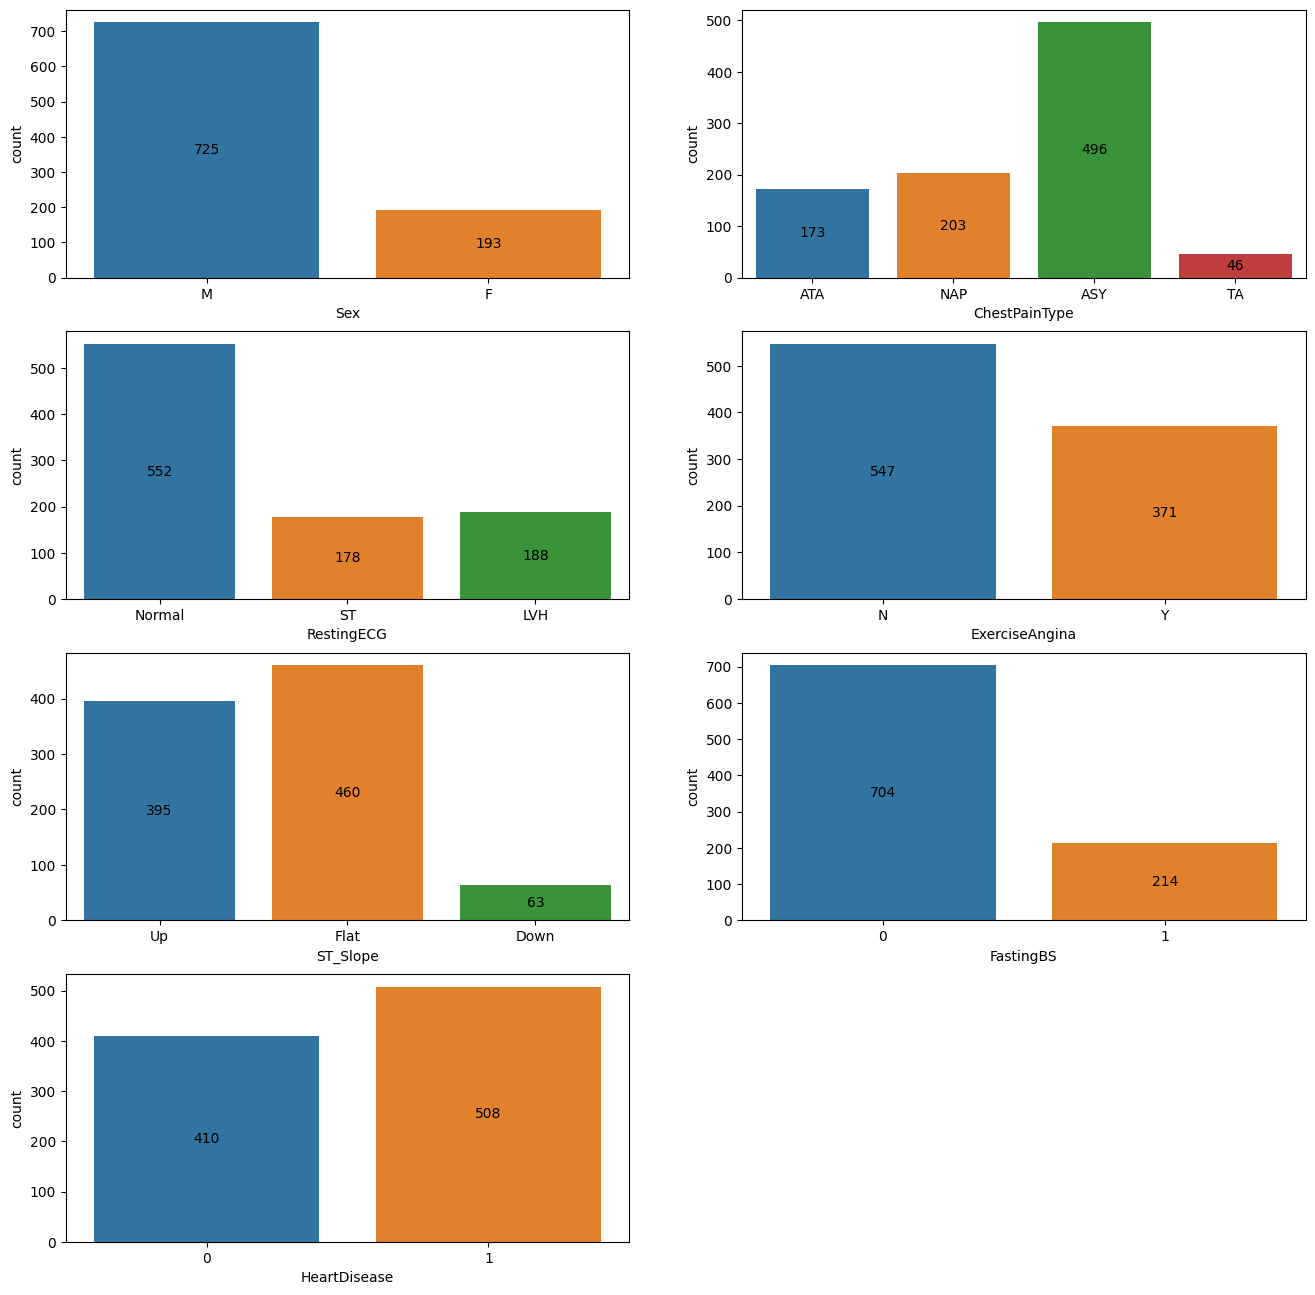

In [7]:
categorical_cols = ["Sex", "ChestPainType", "RestingECG", "ExerciseAngina", "ST_Slope", "FastingBS", "HeartDisease"]
fig = plt.figure(figsize=(16,16))

for x, col in enumerate(categorical_cols):
    ax = plt.subplot(4, 2, x+1)
    sns.countplot(x=df[col], ax=ax)
    for container in ax.containers:
        ax.bar_label(container, label_type="center")

- The dataset is highly skewed towards `male` patients. There are **725** male patients and **193** `female` patients. This could potentially induce a bias in our model.
- **496** patients had `ASY (asymptotic) chest pain` type.
- **552** patients had a normal `restin ECG`.
- **704** patients had blood sugar lower than 120 mg/dl.

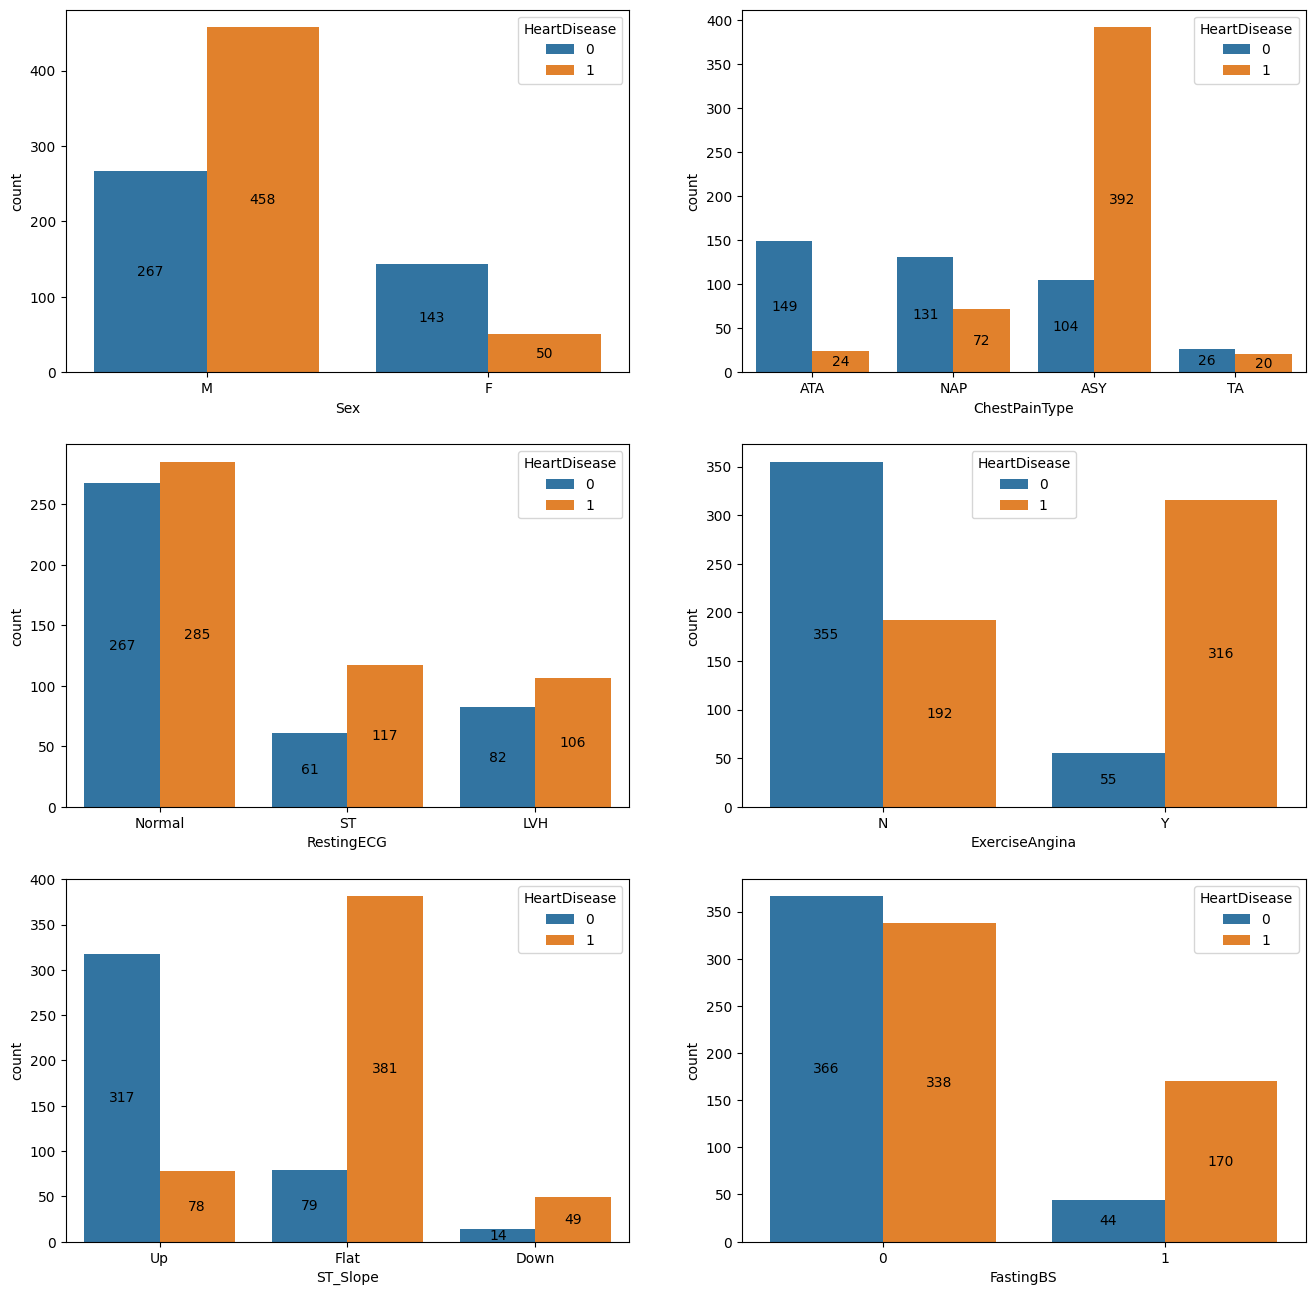

In [8]:
categorical_cols = ["Sex", "ChestPainType", "RestingECG", "ExerciseAngina", "ST_Slope", "FastingBS", "HeartDisease"]
fig = plt.figure(figsize=(16,16))

df['HeartDisease'] = df['HeartDisease'].astype(str)

for x, col in enumerate(categorical_cols[:-1]):
    ax = plt.subplot(3, 2, x+1)
    sns.countplot(x=df[col], hue=df["HeartDisease"], ax=ax)
    for container in ax.containers:
        ax.bar_label(container, label_type="center")
df['HeartDisease'] = df['HeartDisease'].astype(int)

## Heart Disease Patient Statistics

- **Gender and Diagnosis**:
  - Only `50` female patients in the dataset have been diagnosed with heart disease.

- **Chest Pain Type**:
  - A total of `392` patients diagnosed with heart disease have presented with **Asymptomatic (ASY)** chest pain.

- **Exercise-Induced Angina**:
  - Out of all patients who experienced Exercise-Angina, `316` were diagnosed with a heart disease.

- **ST Slope Type**:
  - Among patients with a **Flat** ST Slope, `381` were diagnosed with heart disease.

- **Blood Sugar Levels**:
  - There are `170` patients diagnosed with heart disease who have fasting blood sugar greater than `120 mg/dl`.


## Data Cleaning

A couple of columns have 0 values which don't make sense.

We will look at how many zero values `RestingBP` and `Cholesterol` contain and decide how to handle those.

In [9]:
df[df["RestingBP"] == 0]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
449,55,M,NAP,0,0,0,Normal,155,N,1.5,Flat,1


In [10]:
df[df["Cholesterol"] == 0]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
293,65,M,ASY,115,0,0,Normal,93,Y,0.0,Flat,1
294,32,M,TA,95,0,1,Normal,127,N,0.7,Up,1
295,61,M,ASY,105,0,1,Normal,110,Y,1.5,Up,1
296,50,M,ASY,145,0,1,Normal,139,Y,0.7,Flat,1
297,57,M,ASY,110,0,1,ST,131,Y,1.4,Up,1
...,...,...,...,...,...,...,...,...,...,...,...,...
514,43,M,ASY,122,0,0,Normal,120,N,0.5,Up,1
515,63,M,NAP,130,0,1,ST,160,N,3.0,Flat,0
518,48,M,NAP,102,0,1,ST,110,Y,1.0,Down,1
535,56,M,ASY,130,0,0,LVH,122,Y,1.0,Flat,1


## Handling Zero Values in Cholesterol Column

### Problem Statement

In our heart disease prediction dataset, the `Cholesterol` column has 172 rows with a value of 0, out of 918 total rows.

### Proposed Solutions

We'll explore two methods to address this:

1. **Median Imputation**
2. **K-Nearest Neighbors (KNN) Imputation**

### Evaluation

After applying each method, we'll evaluate:
- Changes in the distribution of the `Cholesterol` column.
- Impact on the overall dataset and subsequent analysis/modeling results.


### Median Method

In [11]:
df_clean_median = df.copy()

df_clean_median = df_clean_median[df_clean_median["RestingBP"] != 0]

heartdisease_mask = df_clean_median["HeartDisease"]==0

cholesterol_without_heartdisease = df_clean_median.loc[heartdisease_mask, "Cholesterol"]
cholesterol_with_heartdisease = df_clean_median.loc[~heartdisease_mask, "Cholesterol"]

df_clean_median.loc[heartdisease_mask, "Cholesterol"] = cholesterol_without_heartdisease.replace(to_replace = 0, value = cholesterol_without_heartdisease.median())
df_clean_median.loc[~heartdisease_mask, "Cholesterol"] = cholesterol_with_heartdisease.replace(to_replace = 0, value = cholesterol_with_heartdisease.median())

In [12]:
df_clean_median[["Cholesterol", "RestingBP"]].describe()

,Cholesterol,RestingBP
count,917.000000,917.000000
mean,239.700109,132.540894
std,54.352727,17.999749
min,85.000000,80.000000
25%,214.000000,120.000000
50%,225.000000,130.000000
75%,267.000000,140.000000
max,603.000000,200.000000


In [13]:
df_clean_median.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


There are no more zero values in either of those.

In [14]:
df_clean_median = pd.get_dummies(data=df_clean_median, drop_first = True)
df_clean_median.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up
0,40,140,289,0,172,0.0,0,True,True,False,False,True,False,False,False,True
1,49,160,180,0,156,1.0,1,False,False,True,False,True,False,False,True,False
2,37,130,283,0,98,0.0,0,True,True,False,False,False,True,False,False,True
3,48,138,214,0,108,1.5,1,False,False,False,False,True,False,True,True,False
4,54,150,195,0,122,0.0,0,True,False,True,False,True,False,False,False,True


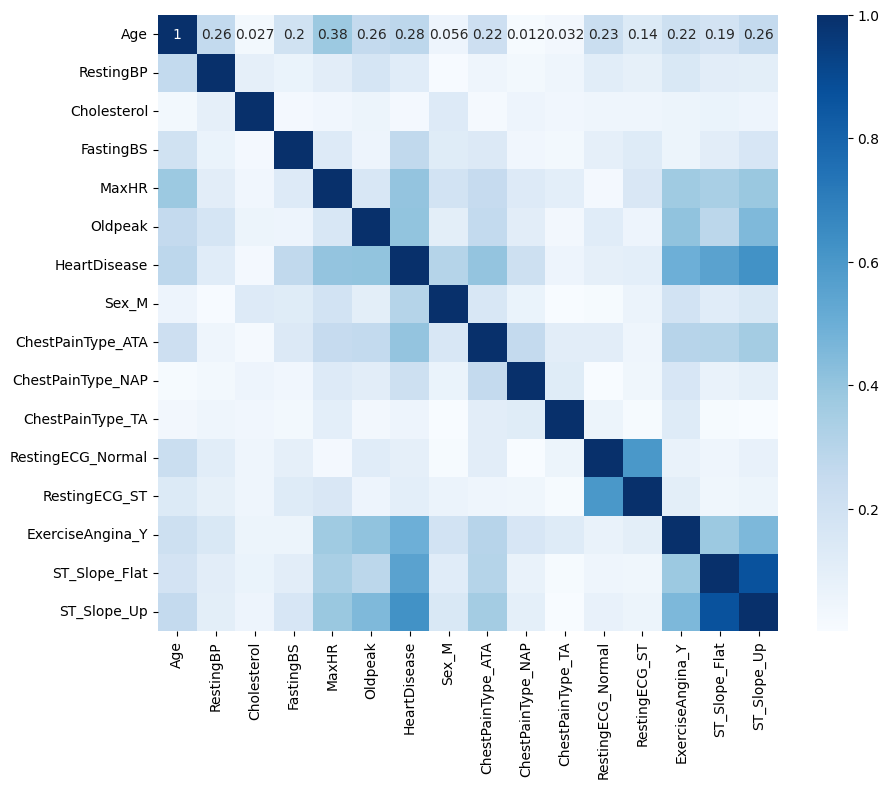

In [15]:
correlations = abs(df_clean_median.corr())
plt.figure(figsize=(10, 8))
sns.heatmap(correlations, annot=True, cmap="Blues")
plt.show()

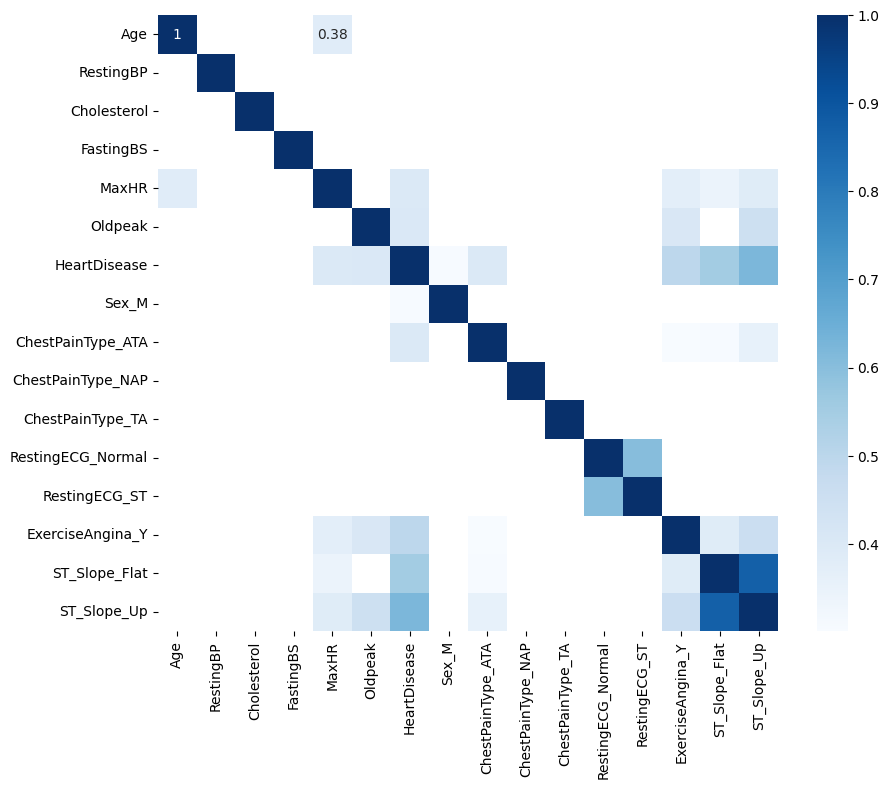

In [16]:
plt.figure(figsize=(10,8))
sns.heatmap(correlations[correlations > 0.3], annot=True, cmap="Blues")
plt.show()

From correlation heatmap, we can identify the following features to be positively correlated (correlation coefficient greater than 0.3) to HeartDisease:

- `Oldpeak`
- `MaxHR`
- `ChestPainType_ATA`
- `ExerciseAngina_Y`
- `ST_Slope_Flat`
- `ST_Slope_Up`

The correlation coefficient threshold was chosen arbitrarily. Surprisingly, `Cholesterol` is not strongly correlated to HeartDisease. We can consider ignoring the feature for now.

Given everything we have attempted so far, we can narrow down our features to the following:

- `Oldpeak`
- `Sex_M`
  - It has a relatively low value for the coefficient, but given what we observed in our EDA, let's also take it into account.
- `MaxHR`
- `ChestPainType_ATA`
- `ExerciseAngina_Y`
- `ST_Slope_Flat`
- `ST_Slope_Up`
Time to create our model using these features!

## Building Model With Median Data

In [17]:
X = df_clean_median.drop("HeartDisease", axis=1)
y = df_clean_median["HeartDisease"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=417)

features = ["Oldpeak", "Sex_M", "MaxHR", "ChestPainType_ATA", "ExerciseAngina_Y", "ST_Slope_Flat", "ST_Slope_Up"]
accuracy = {}
for feature in features:
    knn = KNeighborsClassifier(n_neighbors=3)
    knn.fit(X_train[[feature]], y_train)
    accuracy[f"{feature}: "] =  knn.score(X_test[[feature]], y_test)

accuracy = pd.DataFrame.from_dict(accuracy, orient="index")
accuracy = accuracy.rename(columns={0: 'Accuracy'})
accuracy

,Accuracy
Oldpeak:,0.586957
Sex_M:,0.615942
MaxHR:,0.550725
ChestPainType_ATA:,0.449275
ExerciseAngina_Y:,0.731884
ST_Slope_Flat:,0.818841
ST_Slope_Up:,0.550725


In [18]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train[features])
X_test_scaled = scaler.transform(X_test[features])

knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train_scaled, y_train)
print(f"Accuracy: %{knn.score(X_test_scaled, y_test) * 100:.2f}")

Accuracy: %85.51


### Hyperparameter Optimization

In [25]:
X = df_clean_median.drop("HeartDisease", axis=1)
y = df_clean_median["HeartDisease"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=417)

features = ["Oldpeak", "Sex_M", "MaxHR", "ChestPainType_ATA", "ExerciseAngina_Y", "ST_Slope_Flat", "ST_Slope_Up"]
# Cholesterol Decreased the Accuracy. From %85.51 to %84.06
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train[features])

grid_params = {"n_neighbors": range(1, 20),
                "metric": ["minkowski", "manhattan"]
              }
knn = KNeighborsClassifier()
knn_grid = GridSearchCV(knn, grid_params, scoring="accuracy")
knn_grid.fit(X_train_scaled, y_train)
print(f"Accuracy: %{knn_grid.best_score_*100:.2f}")
print(f"Best Parameters: {knn_grid.best_params_}")

Accuracy: %84.08
Best Parameters: {'metric': 'minkowski', 'n_neighbors': 19}


Since `GridSearchCV` employs a cross-validation approach, it is reasonable to assume that this is a better estimate of how the model performs compared to our prior attempt.

### Model Evaluation on Test set

In [20]:
X_test_scaled = scaler.transform(X_test[features])
predictions = knn_grid.best_estimator_.predict(X_test_scaled)
accuracy = accuracy_score(y_test, predictions)
print(f" Model Accuracy on test set: %{accuracy*100:.2f}")

 Model Accuracy on test set: %85.51


### K-Nearest Neighbors Method (for filling Cholesterol)

In [21]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler

df_clean_knn = df.copy()
df_clean_knn = pd.get_dummies(data=df_clean_knn, drop_first=True)

X = df_clean_knn.drop("Cholesterol", axis=1)
y = df_clean_knn["Cholesterol"]

y_train = y[y != 0]
X_train = X.loc[y_train.index]
X_test = X[y == 0]

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

knn = KNeighborsRegressor(n_neighbors=3)
knn.fit(X_train_scaled, y_train)

predicted_cholesterol = knn.predict(X_test_scaled)

mask = df_clean_knn['Cholesterol'] == 0

predicted_cholesterol_int = predicted_cholesterol.round().astype(int)

df_clean_knn.loc[mask, 'Cholesterol'] = predicted_cholesterol_int

df_clean_knn["Cholesterol"].describe()

count    918.000000
mean     244.755991
std       56.561731
min       85.000000
25%      210.000000
50%      238.000000
75%      273.750000
max      603.000000
Name: Cholesterol, dtype: float64

### Hyperparameter Optimization

In [24]:
X = df_clean_knn.drop("HeartDisease", axis=1)
y = df_clean_knn["HeartDisease"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=417)

features = ["Oldpeak", "Sex_M", "MaxHR", "ChestPainType_ATA", "ExerciseAngina_Y", "ST_Slope_Flat", "ST_Slope_Up"]
# Cholesterol decreased the Accuracy. From %85.51 to %84.78
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train[features])

grid_params = {"n_neighbors": range(1, 20),
                "metric": ["minkowski", "manhattan"]
              }

knn = KNeighborsClassifier()
knn_grid = GridSearchCV(knn, grid_params, scoring="accuracy")
knn_grid.fit(X_train_scaled, y_train)
print(f"Accuracy: %{knn_grid.best_score_*100:.2f}")
print(f"Best Parameters: {knn_grid.best_params_}")

Accuracy: %83.97
Best Parameters: {'metric': 'minkowski', 'n_neighbors': 18}


### Model Evaluation on Test set

In [23]:
X_test_scaled = scaler.transform(X_test[features])
predictions = knn_grid.best_estimator_.predict(X_test_scaled)
accuracy = accuracy_score(y_test, predictions)
print(f" Model Accuracy on test set: %{accuracy*100:.2f}")

 Model Accuracy on test set: %85.51


We can see that `Median` and `kNN` methods gave us the same accuracy! 